In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
!pip install xgboost
!pip install seaborn
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 557.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
tickers = [
                   'BHARTIARTL.NS', 'LTIM.NS', 'HDFCLIFE.NS', 'NTPC.NS', 'MARUTI.NS',
                   'NESTLEIND.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'TATASTEEL.NS',
                   'ONGC.NS', 'BAJAJ-AUTO.NS', 'LT.NS', 'ITC.NS', 'TCS.NS', 'BRITANNIA.NS',
                   'ADANIENT.NS', 'CIPLA.NS', 'WIPRO.NS', 'INDUSINDBK.NS',
                   'ULTRACEMCO.NS', 'TATACONSUM.NS', 'BAJAJFINSV.NS', 'RELIANCE.NS',
                   'HEROMOTOCO.NS', 'COALINDIA.NS', 'TITAN.NS', 'HINDALCO.NS',
                   'APOLLOHOSP.NS','TECHM.NS','DRREDDY.NS','DIVISLAB.NS','EICHERMOT.NS','BPCL.NS','SBILIFE.NS',
                   'LTIM.NS','GRASIM.NS','JSWSTEEL.NS','ASIANPAINT.NS','POWERGRID.NS','ADANIPORTS.NS','M&M.NS',
                   'TATAMOTORS.NS','SUNPHARMA.NS','AXISBANK.NS','HCLTECH.NS','HINDUNILVR.NS','INFY.NS','SBIN.NS',
                   'ICICIBANK.NS','HDFCBANK.NS'
    ]

In [ ]:
import xgboost as xg
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [ ]:
def calculate_features(data, horizon=21):
    features = pd.DataFrame(index=data.index)
    features['Close'] = data['Close']

    features['returns'] = data['Close'].pct_change()
    features['returns_20'] = (data['Close'].rolling(20).mean()).pct_change()
    features['volatility_20'] = data['Close'].rolling(20).std()
    features['ma_10'] = data['Close'].rolling(10).mean()
    features['ma_50'] = data['Close'].rolling(50).mean()
    features['momentum_10'] = (data['Close'].rolling(10).mean()).pct_change(horizon)
    features['momentum_50'] = (data['Close'].rolling(50).mean()).pct_change(horizon)
    features['upper_band'] = data['Close'].rolling(20).mean() + 2 * data['Close'].rolling(20).std()
    features['lower_band'] = data['Close'].rolling(20).mean() - 2 * data['Close'].rolling(20).std()
    features['corr_close_vol_20'] = data['Close'].rolling(20).corr(data['Volume'])
    for lag in [1, 2, 3, 5]:
        features[f'return_lag_{lag}'] = features['returns'].shift(lag)


    return features

In [ ]:
start_date='2022-03-01'
end_date='2024-05-31'

data=yf.download(tickers,start=start_date,end=end_date,interval="1d")
returns=data["Close"].pct_change().dropna()
returns=returns*100

/tmp/ipython-input-4116705178.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data=yf.download(tickers,start=start_date,end=end_date,interval="1d")
[*********************100%***********************]  49 of 49 completed


In [ ]:
data

Price             Close                                            \
Ticker      ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2022-03-02  1638.783691    694.330994   4813.965332   2921.569336   
2022-03-03  1640.780151    690.811951   4869.964844   2770.086914   
2022-03-04  1612.032959    684.409241   4701.074219   2641.078369   
2022-03-07  1561.176514    662.561646   4618.979980   2612.431152   
2022-03-08  1598.657471    673.363220   4676.317383   2626.851074   
...                 ...           ...           ...           ...   
2024-05-24  3381.856201   1403.223267   5896.933105   2816.345703   
2024-05-27  3286.043945   1418.631958   5921.808594   2813.945801   
2024-05-28  3241.085205   1387.765137   5887.111816   2852.055176   
2024-05-29  3255.821533   1397.178711   5886.064941   2841.229492   
2024-05-30  3191.330566   1370.919678   5749.468750   2825.114014   

Price                                                              \
Ticker      AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2022-03-02   747.130432   3050.997559   1602.084961    671.186890   
2022-03-03   734.582886   2982.962646   1567.264893    663.012634   
2022-03-04   712.027039   2933.202637   1530.249023    642.336243   
2022-03-07   664.774292   2926.462158   1434.441284    601.769653   
2022-03-08   667.612488   3001.057129   1442.175781    605.390076   
...                 ...           ...           ...           ...   
2024-05-24  1172.093018   8656.667969   1599.910522    677.022888   
2024-05-27  1185.071899   8705.522461   1594.017334    682.825745   
2024-05-28  1181.477661   8696.864258   1597.863037    680.602600   
2024-05-29  1157.866089   8774.693359   1568.146118    674.032288   
2024-05-30  1166.052734   8676.306641   1522.397339    655.192871   

Price                                 ...    Volume               \
Ticker     BHARTIARTL.NS     BPCL.NS  ...   SBIN.NS SUNPHARMA.NS   
Date                                  ...                          
2022-03-02    658.984924  148.594574  ...  22003848      3807036   
2022-03-03    656.834717  150.462311  ...  20358590      2657776   
2022-03-04    638.900146  151.309311  ...  20684268      4082674   
2022-03-07    660.108887  146.813660  ...  33720472      3065234   
2022-03-08    667.536804  148.377380  ...  42510207      4864275   
...                  ...         ...  ...       ...          ...   
2024-05-24   1369.357422  306.148926  ...  12252075      5307322   
2024-05-27   1365.264526  307.061615  ...  12295193      3474806   
2024-05-28   1352.147949  302.591766  ...  13818893      2616438   
2024-05-29   1358.114502  296.530548  ...  14518232      2843365   
2024-05-30   1358.163940  292.879791  ...  17818705      3133423   

Price                                                                  \
Ticker     TATACONSUM.NS TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS   
Date                                                                    
2022-03-02       1938441      25791134    248475320  2761341  2160190   
2022-03-03       2112330      29599672    174503380  1928039  2730530   
2022-03-04       2833168      38765185    162829230  2370257  3567738   
2022-03-07       2137318      44836205    110400010  3054130  3341715   
2022-03-08       2850859      55543383     91078220  3300992  2365949   
...                  ...           ...          ...      ...      ...   
2024-05-24       1424791       9590588     38674485  1309452  1288301   
2024-05-27       1881215       6916555     30410585  1841538   980450   
2024-05-28        981637       6618946     39208456  1801993  1608944   
2024-05-29       1526469       8184019     36575550  1568095  1405567   
2024-05-30       2743237      10170912    108813875  2919230  2610479   

Price                                        
Ticker     TITAN.NS ULTRACEMCO.NS  WIPRO.NS 

In [ ]:
returns

Ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
Date                                                                   
2022-03-03     0.121826      -0.506825       1.163272      -5.184968   
2022-03-04    -1.752044      -0.926838      -3.468005      -4.657202   
2022-03-07    -3.154802      -3.192183      -1.746287      -1.084679   
2022-03-08     2.400815       1.630275       1.241343       0.551973   
2022-03-09     3.430957       3.665527      -0.239300       5.564742   
...                 ...            ...            ...            ...   
2024-05-24    -0.069378      -1.887968      -0.932985      -0.998702   
2024-05-27    -2.833126       1.098093       0.421838      -0.085213   
2024-05-28    -1.368172      -2.175816      -0.585915       1.354304   
2024-05-29     0.454673       0.678326      -0.017782      -0.379575   
2024-05-30    -1.980789      -1.879433      -2.320671      -0.567201   

Ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
Date                                                                   
2022-03-03    -1.679432      -2.229924      -2.173422      -1.217881   
2022-03-04    -3.070565      -1.668141      -2.361813      -3.118552   
2022-03-07    -6.636370      -0.229799      -6.260925      -6.315476   
2022-03-08     0.426941       2.548981       0.539199       0.601629   
2022-03-09     0.566832       0.660200       3.906392       5.041512   
...                 ...            ...            ...            ...   
2024-05-24     0.750916      -0.170133      -0.419665       0.150148   
2024-05-27     1.107325       0.564357      -0.368345       0.857114   
2024-05-28    -0.303293      -0.099456       0.241259      -0.325580   
2024-05-29    -1.998478       0.894910      -1.859791      -0.965367   
2024-05-30     0.707046      -1.121255      -2.917380      -2.795032   

Ticker      BHARTIARTL.NS   BPCL.NS  ...   SBIN.NS  SUNPHARMA.NS  \
Date                                 ...                           
2022-03-03      -0.326291  1.256935  ... -1.444387      0.000000   
2022-03-04      -2.730454  0.562932  ... -1.166023      1.065904   
2022-03-07       3.319570 -2.971166  ... -4.686655     -0.843730   
2022-03-08       1.125256  1.065106  ...  0.000000      3.932418   
2022-03-09       1.244509  0.307382  ...  2.589137      1.549708   
...                   ...       ...  ...       ...           ...   
2024-05-24       1.051641  1.027110  ... -0.420621     -0.561838   
2024-05-27      -0.298892  0.298119  ...  0.615499     -1.388975   
2024-05-28      -0.960735 -1.455685  ... -0.305859     -0.078441   
2024-05-29       0.441265 -2.003101  ... -1.022682      0.959099   
2024-05-30       0.003640 -1.231157  ...  0.388981     -1.342156   

Ticker      TATACONSUM.NS  TATAMOTORS.NS  TATASTEEL.NS    TCS.NS  TECHM.NS  \
Date                                                                         
2022-03-03      -3.368490      -2.345838      1.081940 -0.049358  2.316496   
2022-03-04      -2.488901      -4.541305     -2.010285 -0.565660  1.889040   
2022-03-07      -1.507588      -5.572199      1.158884 -1.119355 -2.029435   
2022-03-08       3.614455      -0.571072     -1.733887  3.301384  2.657812   
2022-03-09       2.259775       3.612002     -1.114603  0.906961  2.927590   
...                   ...            ...           ...       ...       ...   
2024-05-24      -1.084861      -0.187037     -0.370366 -1.128812 -1.177565   
2024-05-27      -0.942404      -0.213423      0.371743 -0.063647  0.601481   
2024-05-28       0.703192      -1.142409     -0.341884 -0.185860 -1.098002   
2024-05-29      -2.213505      -0.416860     -0.371637 -0.944041 -2.178538   
2024-05-30      -0.382723      -2.082449     -5.796266 -1.775920 -3.544629   

Ticker      TITAN.NS  ULTRACEMCO.NS  WIPRO.NS  
Date                                           
2022-03-03 -0.709707      -6.542069  2.584641  
2022-03-04 -5.176263       1.163741  1.009589  
2022-03-07 -2.101598      -5.82120

In [ ]:
from tqdm import tqdm

In [ ]:
features = ['volatility_20','ma_10','ma_50','momentum_10','momentum_50','upper_band','lower_band','returns_20', 'corr_close_vol_20', 'return_lag_1','return_lag_2','return_lag_3','return_lag_5']
# df_test = yf.download('LTIM.NS',start='2024-06-01',end='2025-07-31',interval="1d",progress=False)[['Close','High','Low']]
expected_returns=pd.DataFrame()
actual_returns=pd.DataFrame()

In [ ]:
#import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
actual_returns = pd.DataFrame()
expected_returns = pd.DataFrame()

for ticker in tqdm(tickers):
    df = pd.DataFrame(index=data.index)
    df['Close'] = data['Close'][ticker]
    df['High'] = data['High'][ticker]
    df['Low'] = data['Low'][ticker]
    df['Volume'] = data['Volume'][ticker]

    df = calculate_features(df)
    df = df.dropna()

    X = df[features]
    y = df['returns']

    model = xg.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X, y,
        eval_set=[(X, y)],
        verbose=False,

    )

    df_test = yf.download(
        ticker, start='2024-06-01', end='2025-07-31',
        interval="1d", progress=False
    )[['Close', 'High', 'Low','Volume']]

    df_test = calculate_features(df_test)
    df_test = df_test.dropna()

    actual_returns[ticker] = df_test['Close'].pct_change().dropna()
    expected_returns[ticker] = pd.Series(
        model.predict(df_test[features]),
        index=df_test.index
    )

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-1976782370.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(
  2%|▏         | 1/50 [00:12<10:35, 12.97s/it]/tmp/ipython-input-1976782370.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(
  4%|▍         | 2/50 [00:22<08:36, 10.76s/it]/tmp/ipython-input-1976782370.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(
  6%|▌         | 3/50 [00:30<07:32,  9.62s/it]/tmp/ipython-input-1976782370.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(
  8%|▊         | 4/50 [00:39<07:07,  9.30s/it]/tmp/ipython-input-1976782370.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_test = yf.download(
 10%|█         | 5/50 [00:46<06:18,  8.42s/it]/tmp/ipython-input-1976782370.py

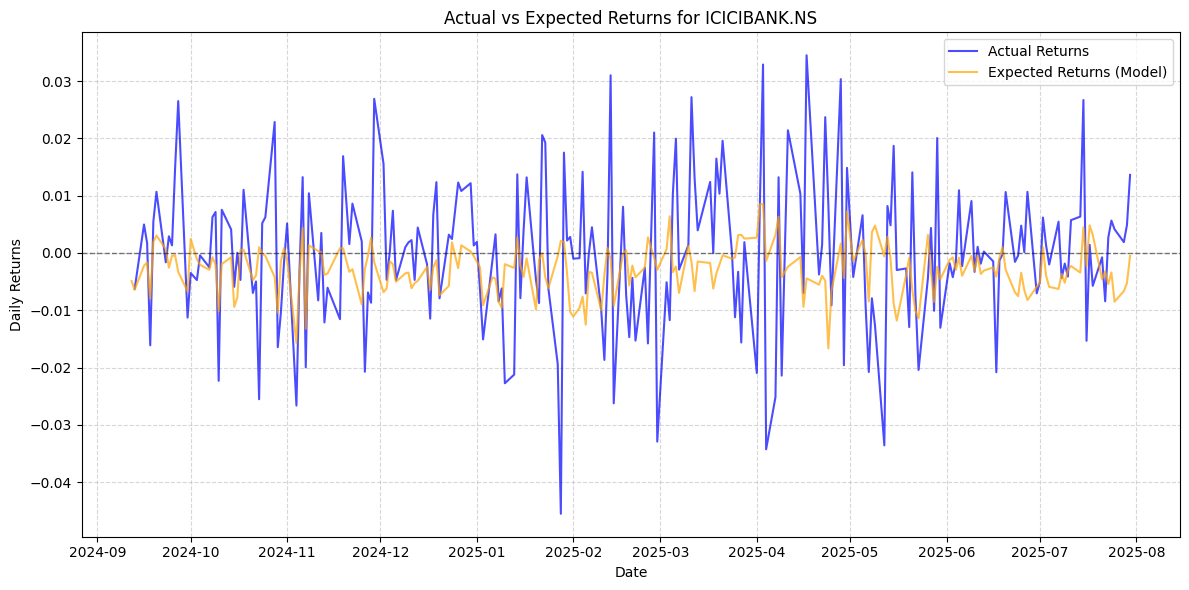

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual_returns.index, actual_returns['SUNPHARMA.NS'], label='Actual Returns', color='blue', alpha=0.7)
plt.plot(expected_returns.index, expected_returns['SUNPHARMA.NS'], label='Expected Returns (Model)', color='orange', alpha=0.7)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.title(f"Actual vs Expected Returns for ICICIBANK.NS")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3406601835.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))


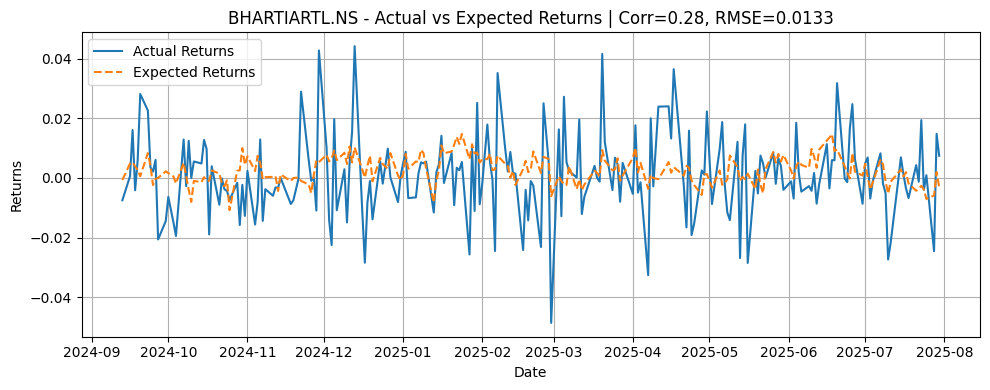

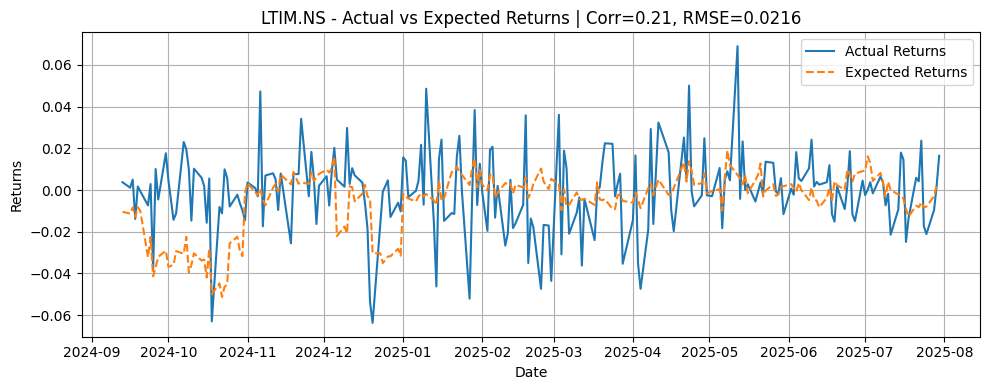

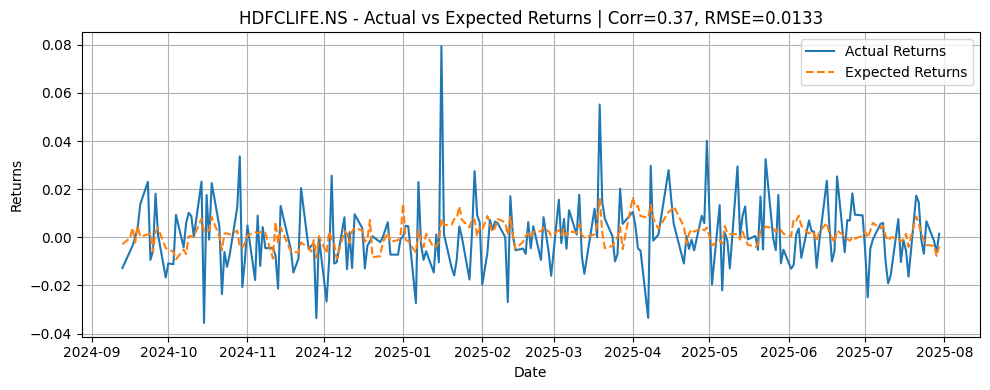

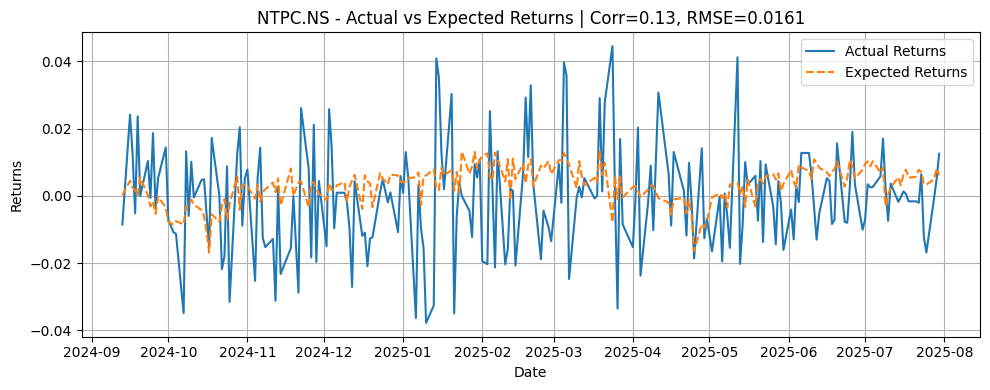

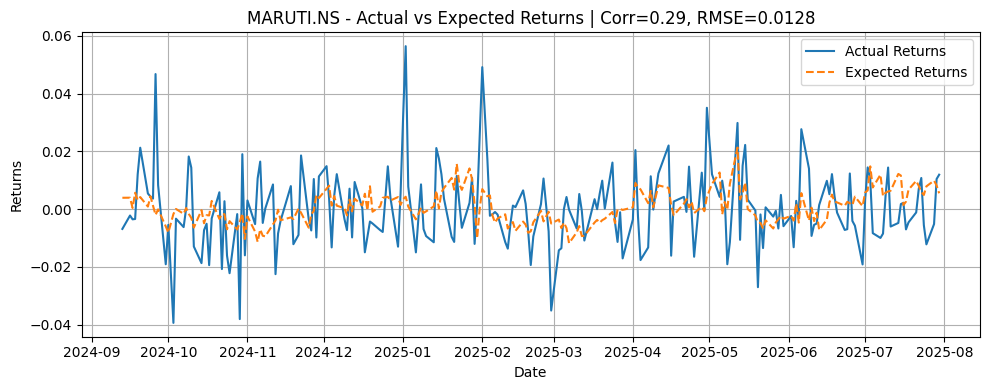

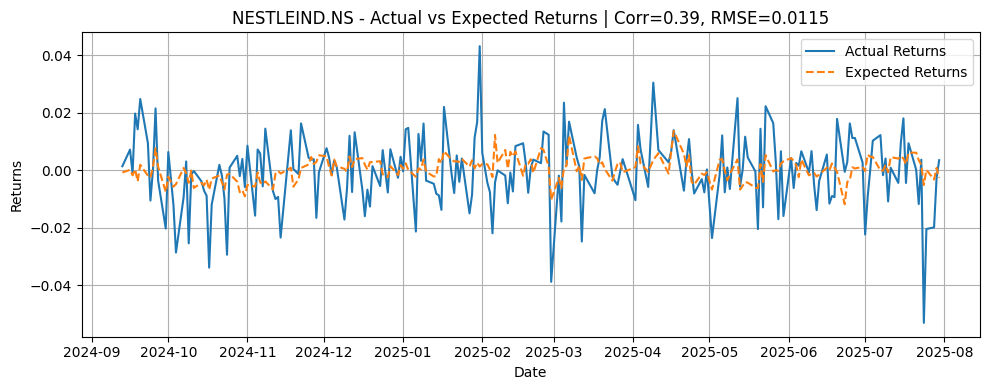

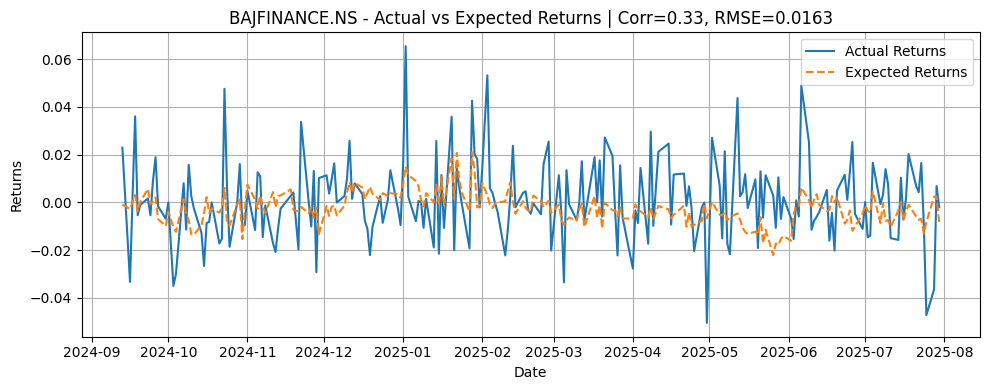

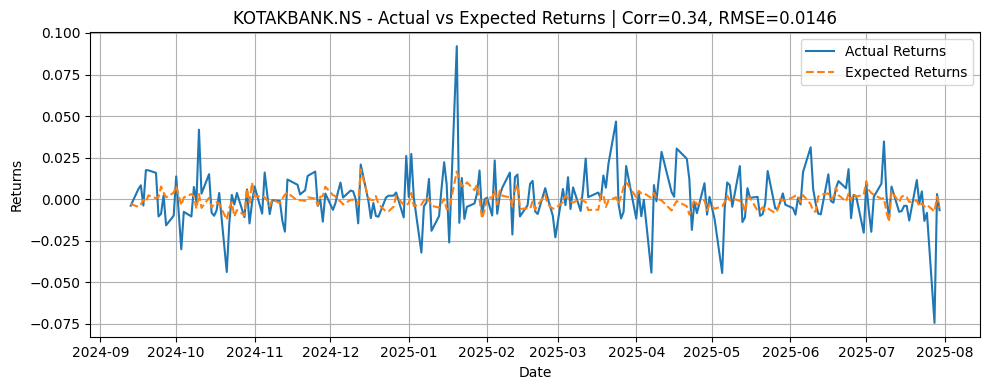

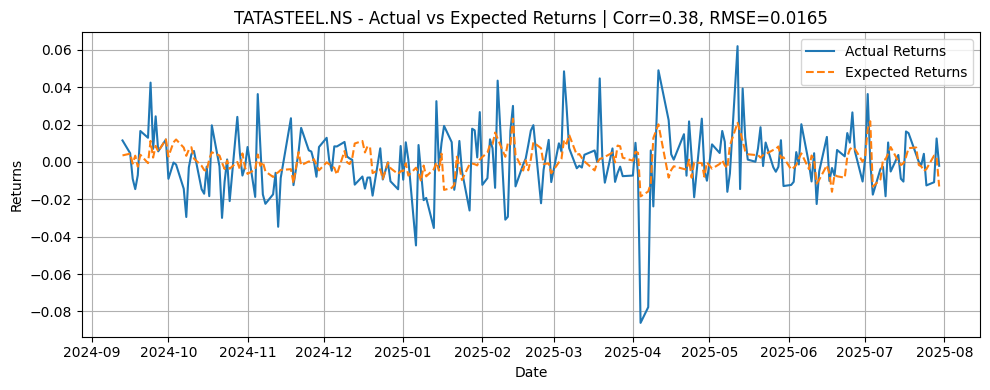

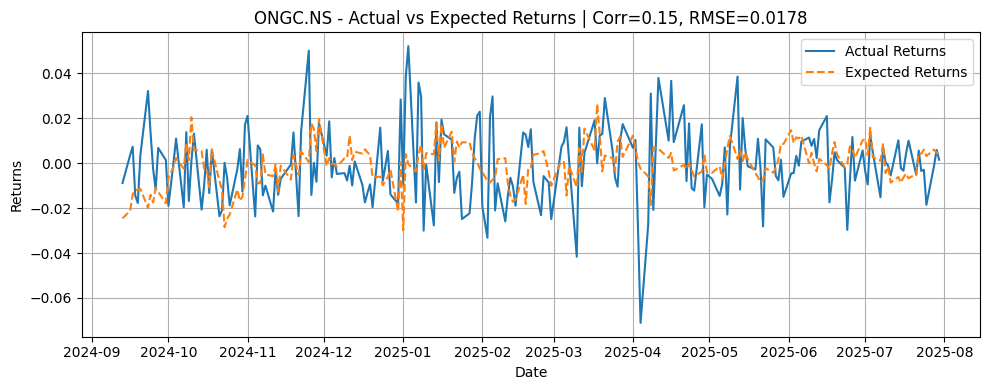

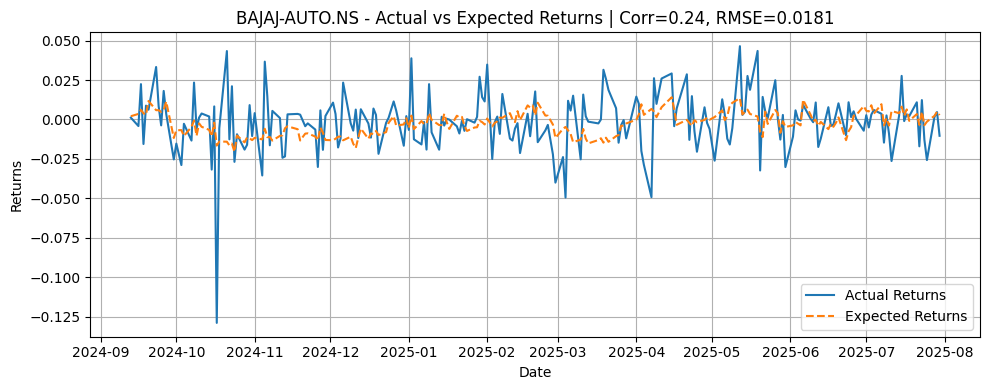

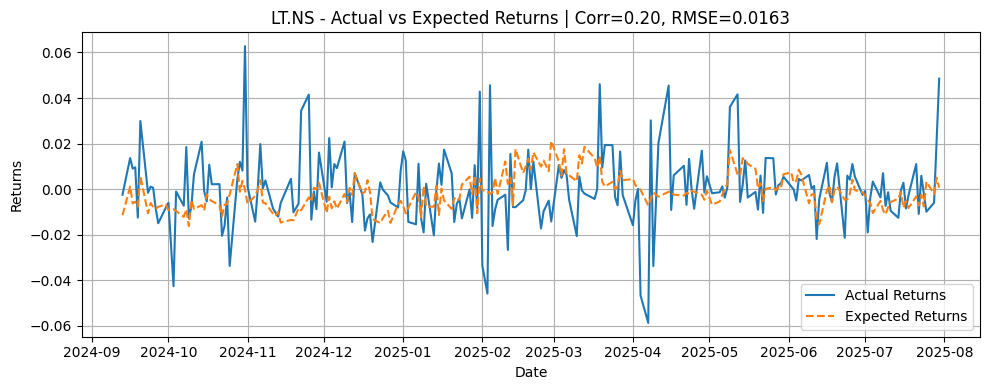

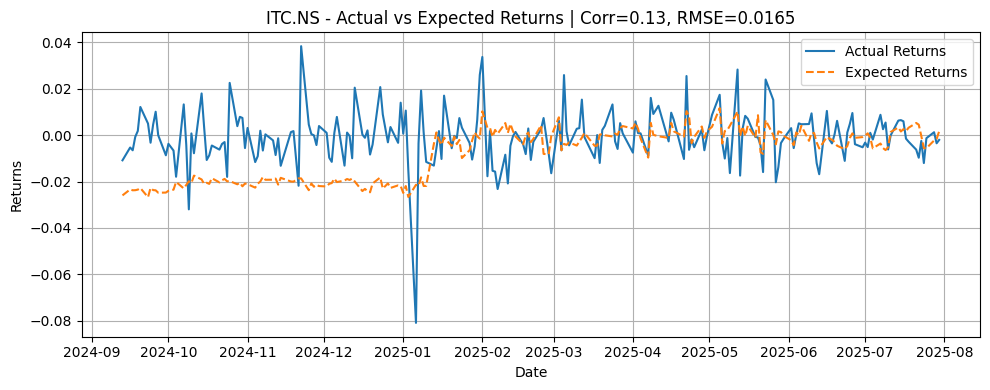

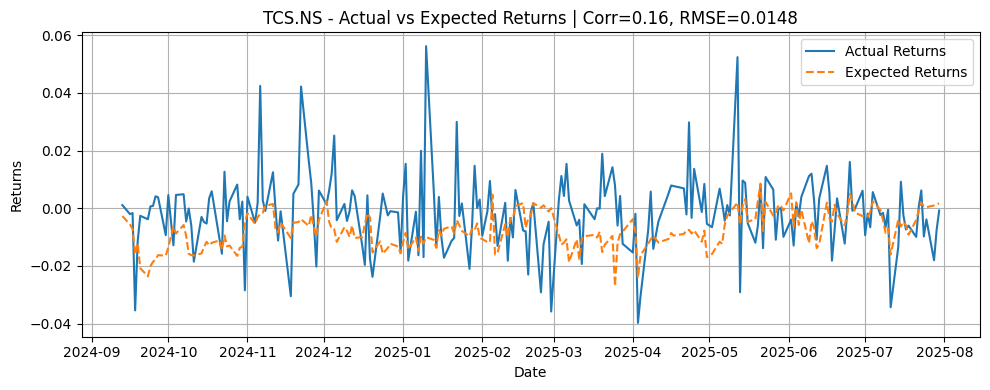

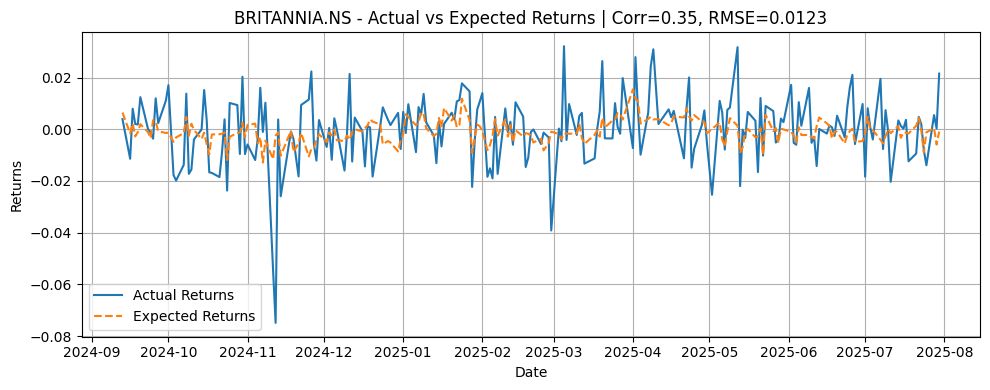

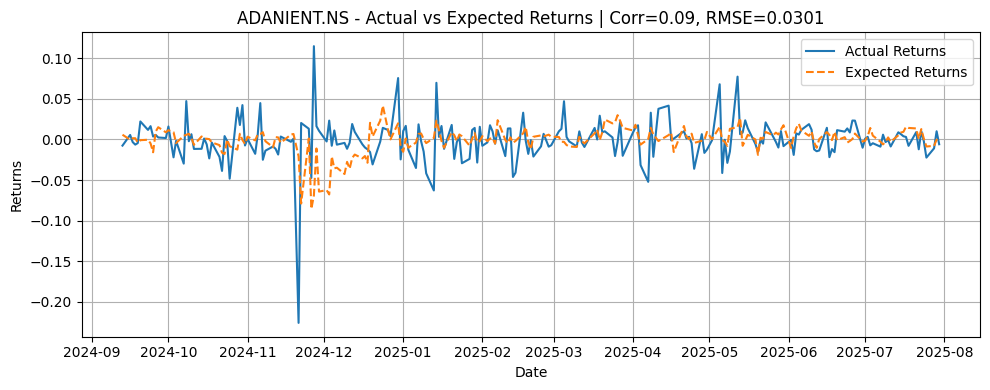

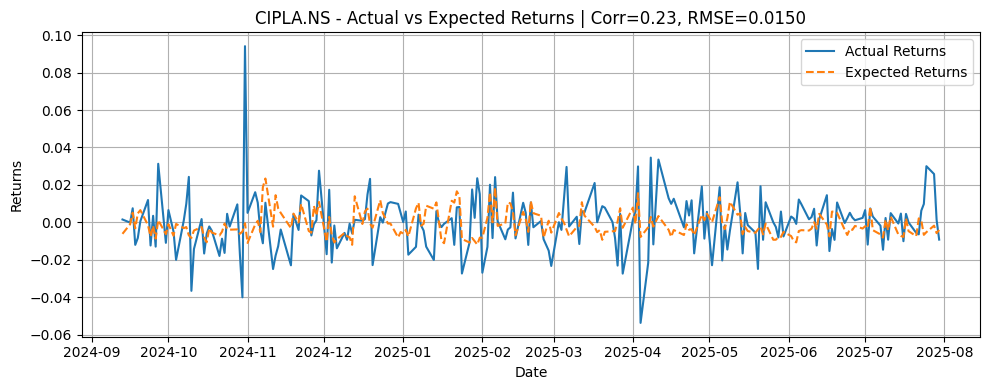

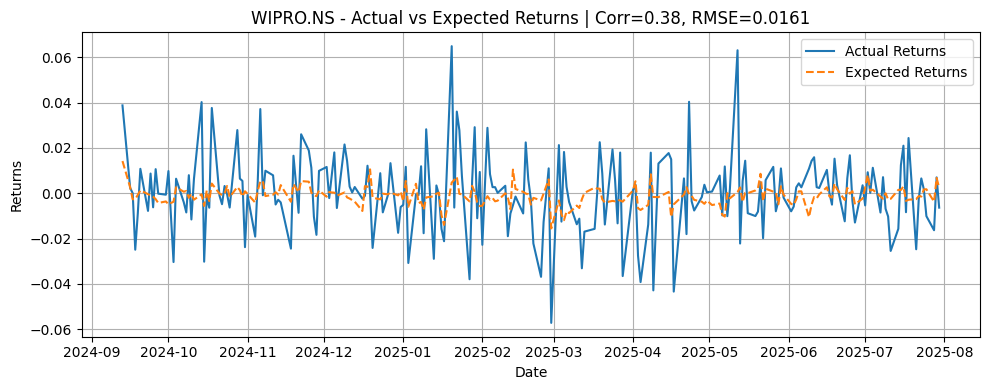

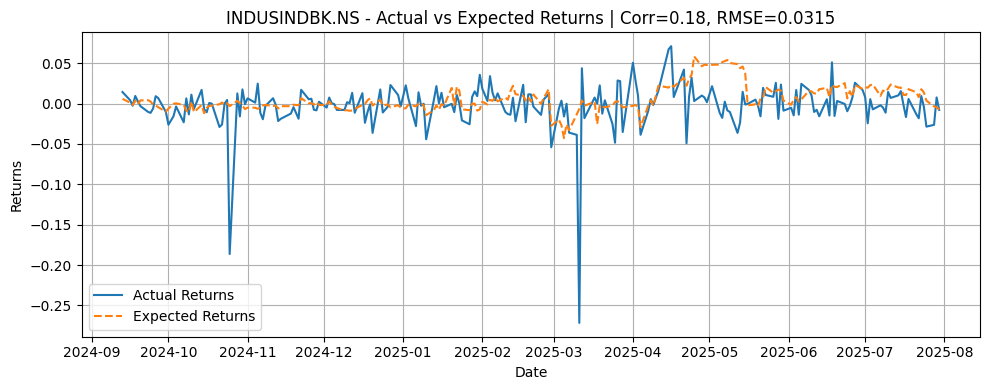

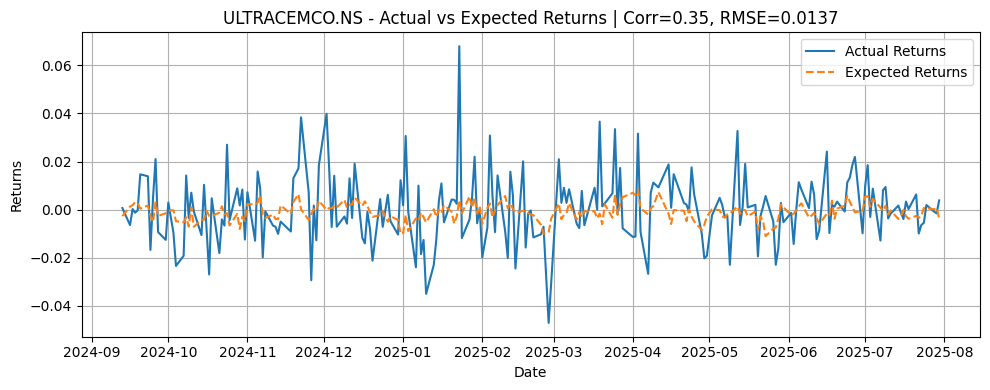

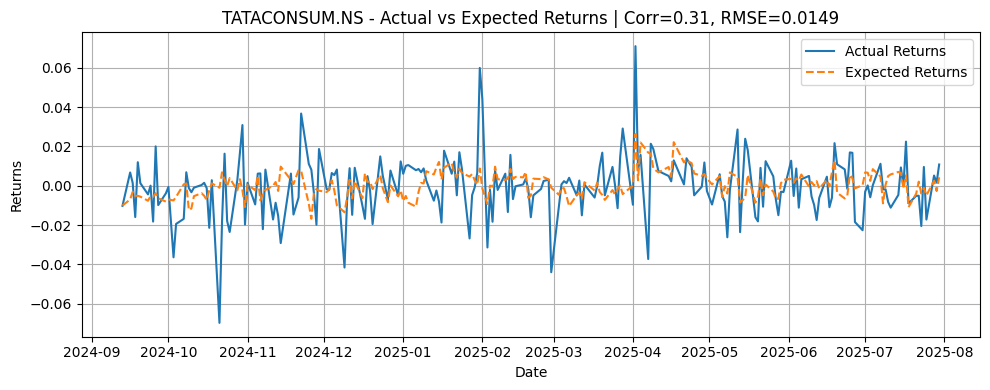

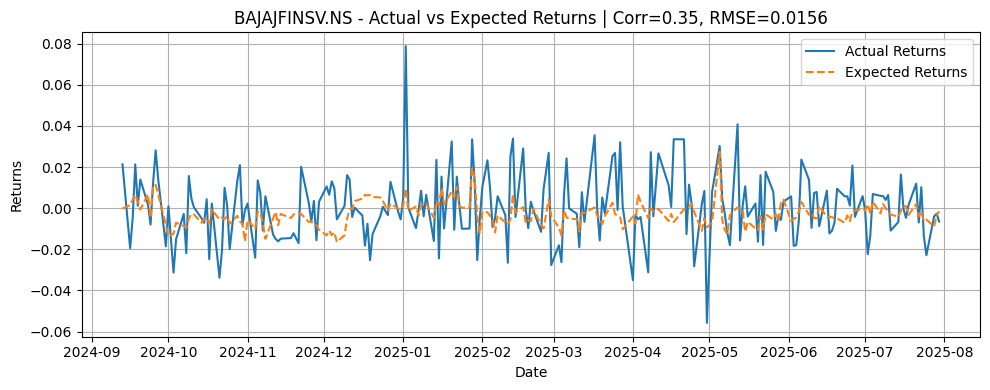

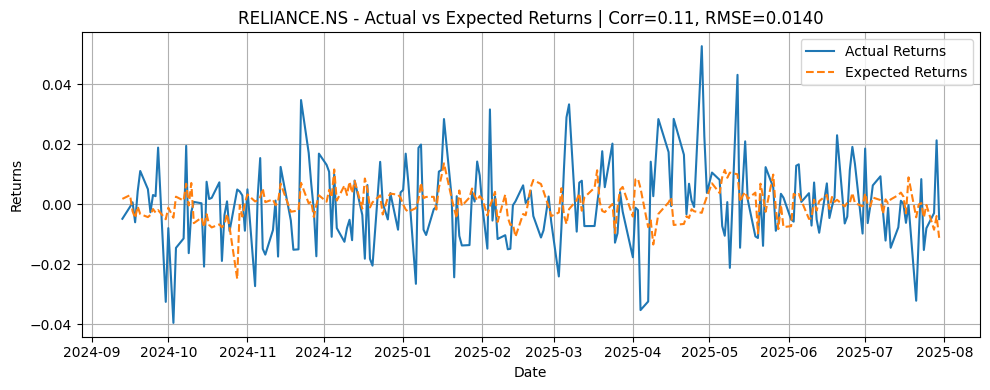

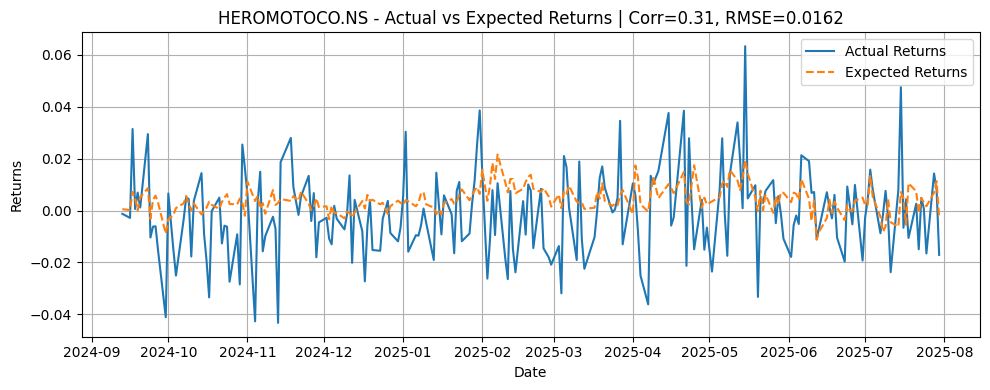

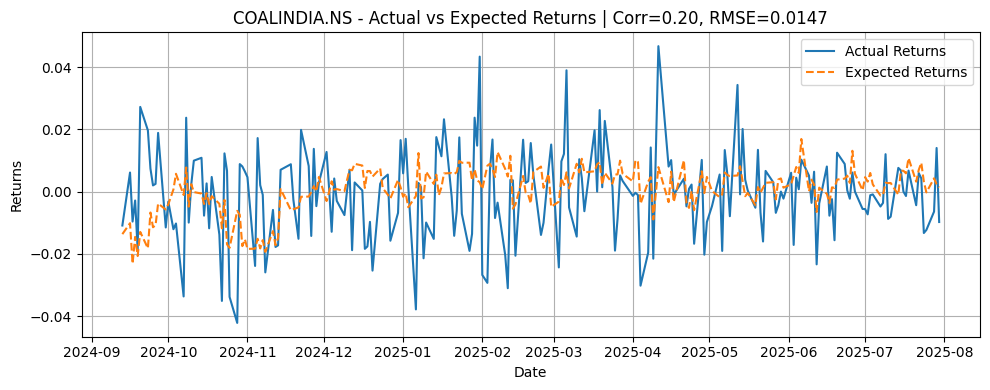

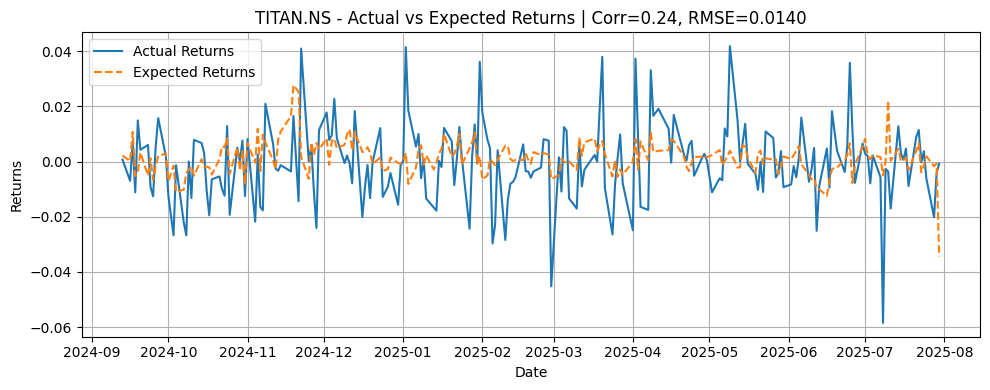

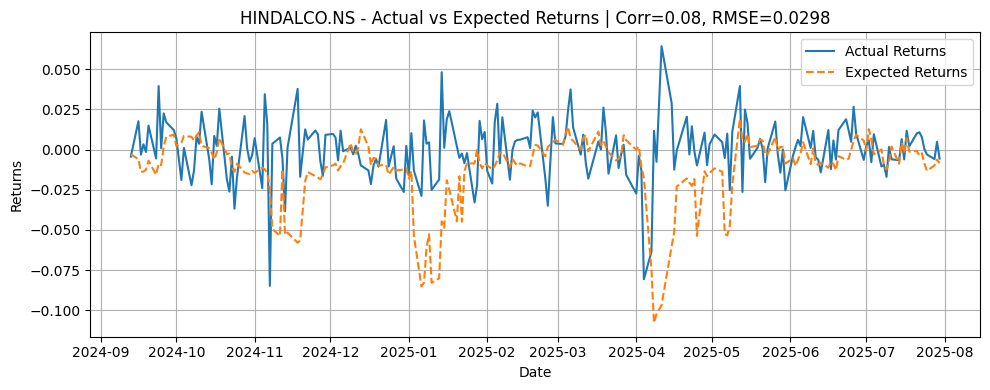

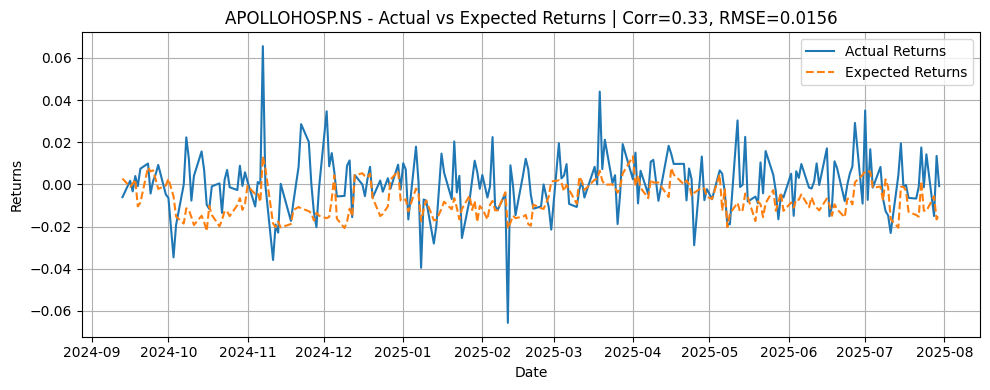

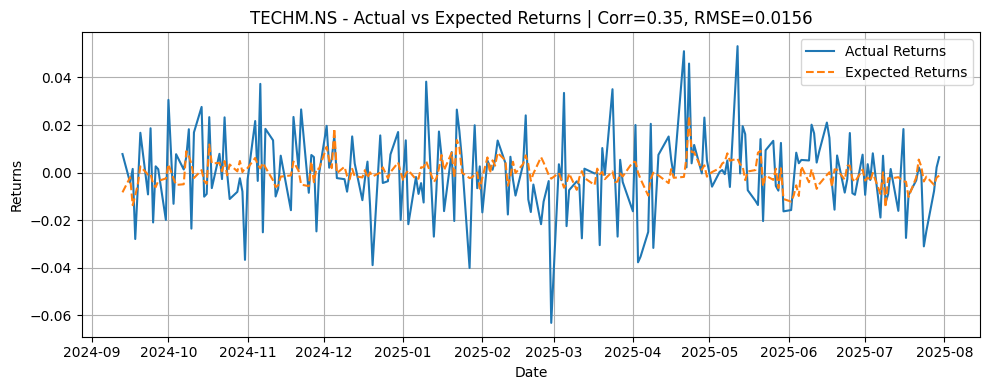

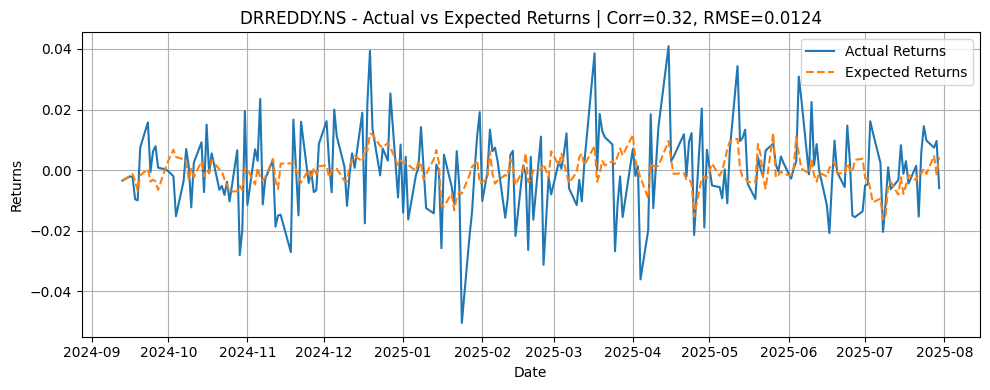

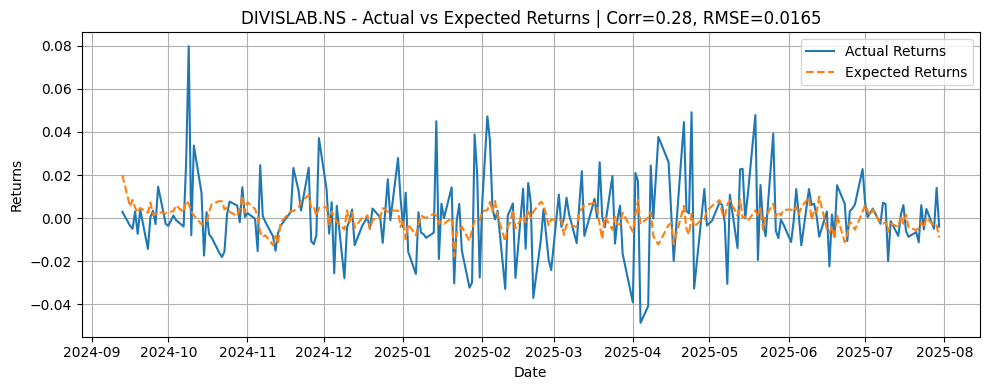

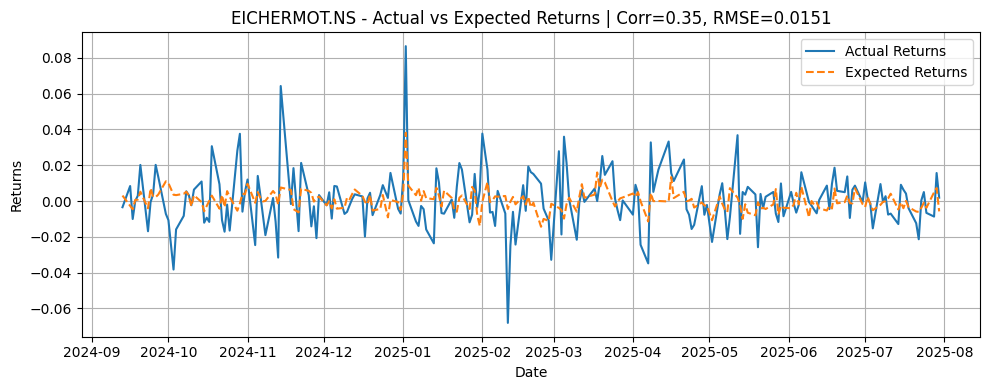

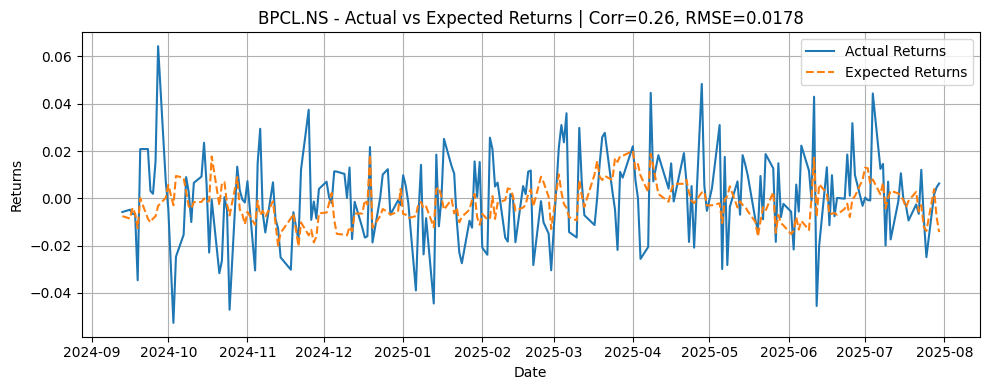

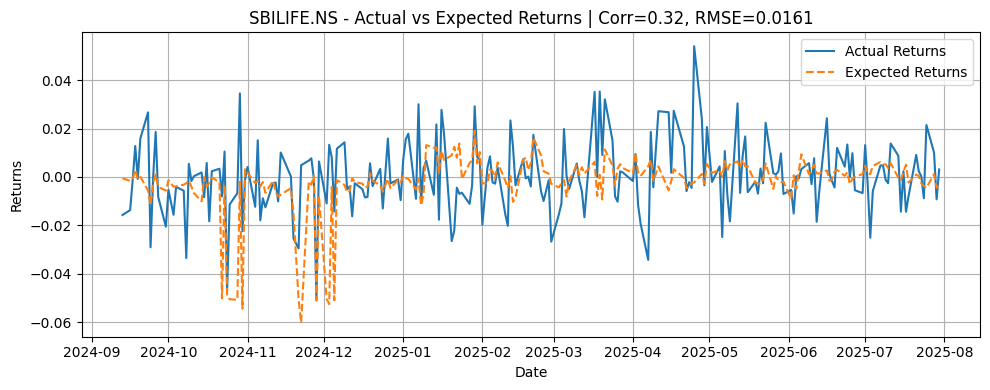

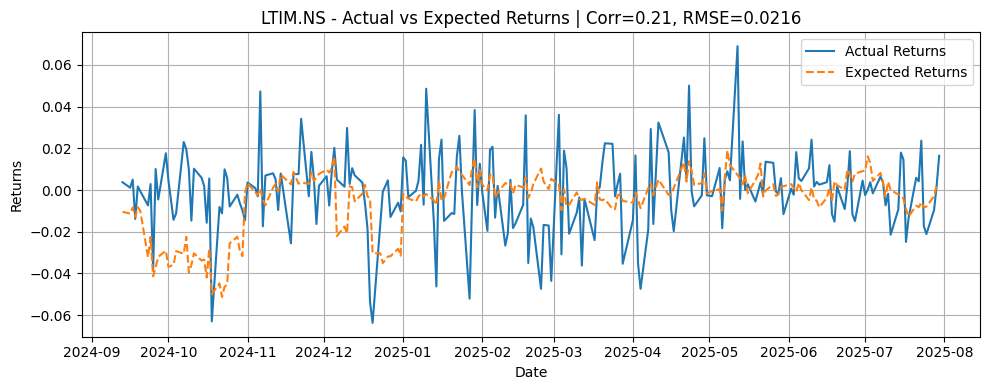

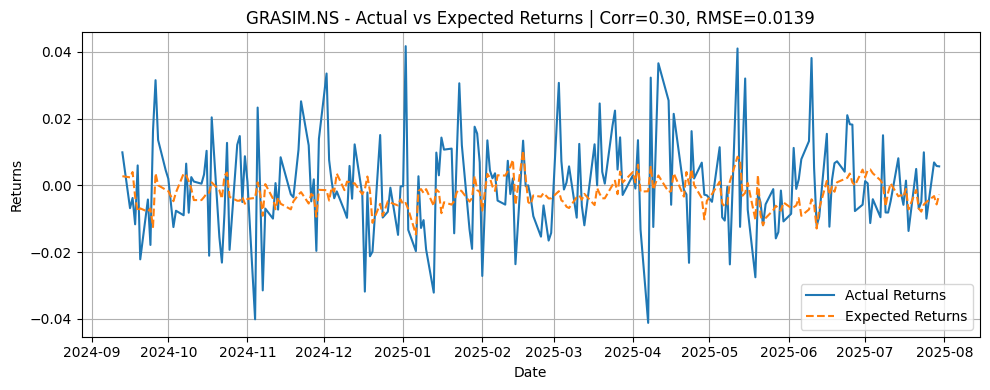

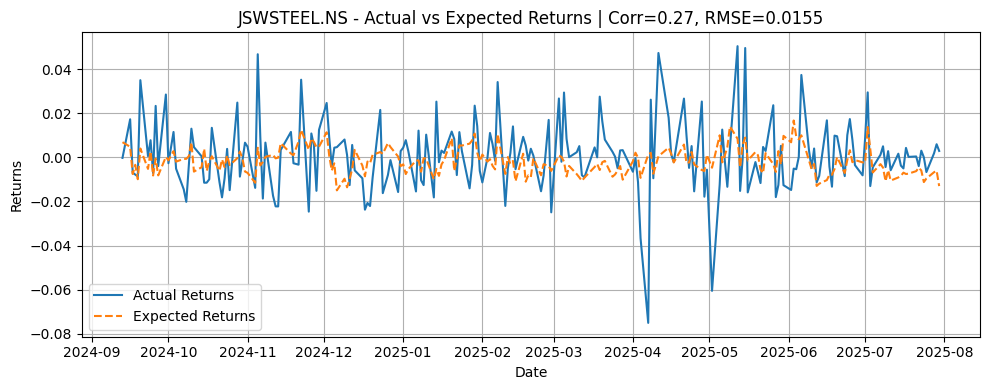

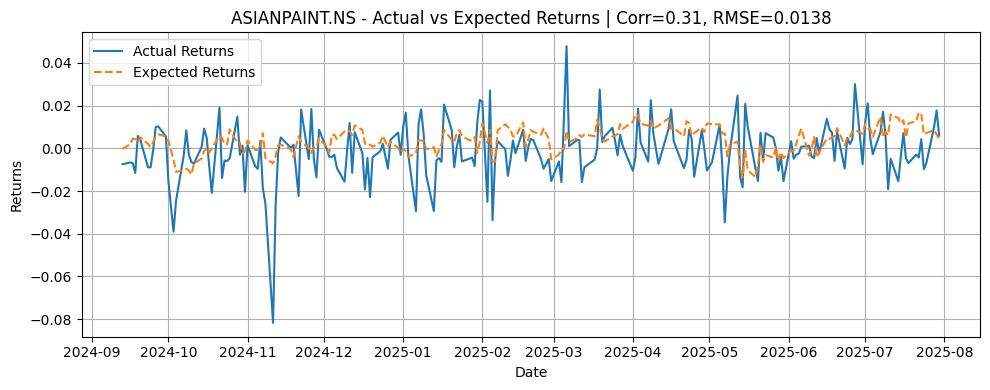

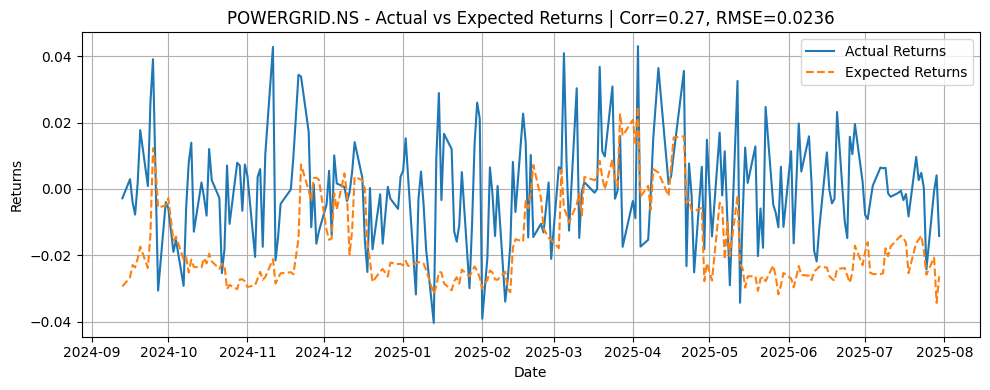

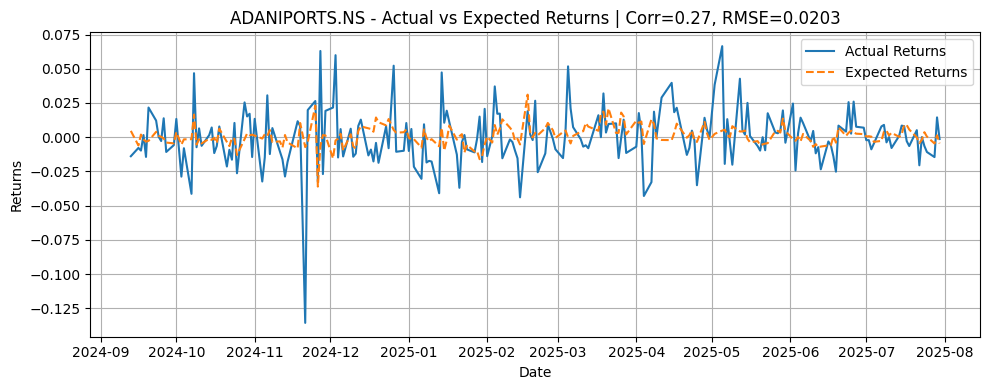

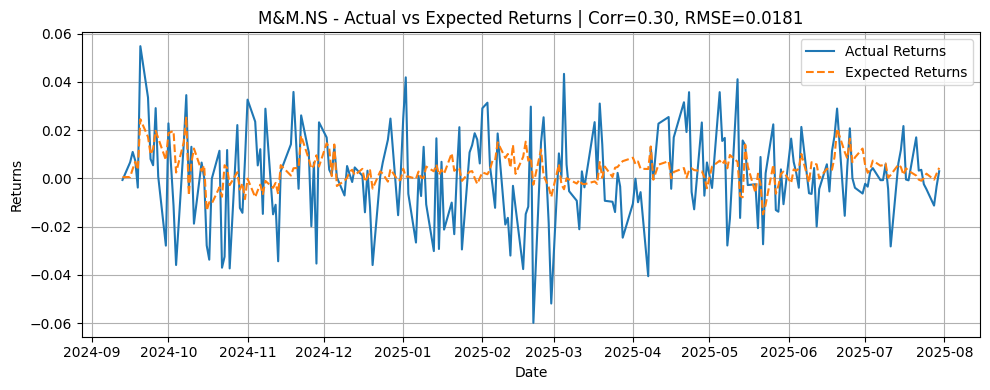

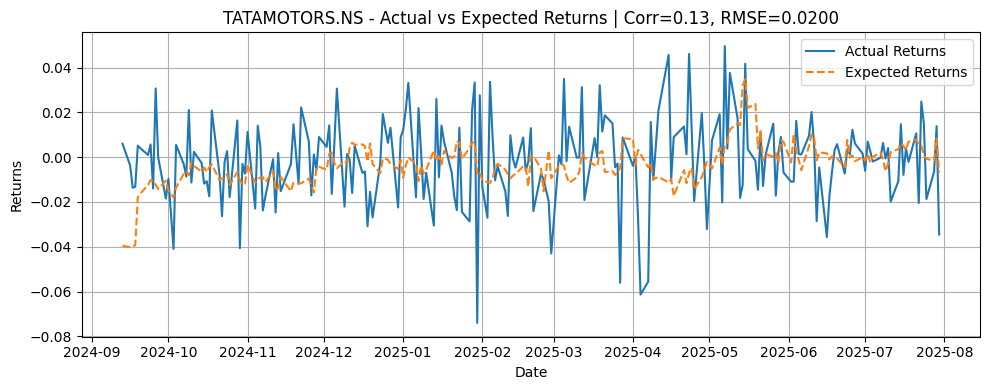

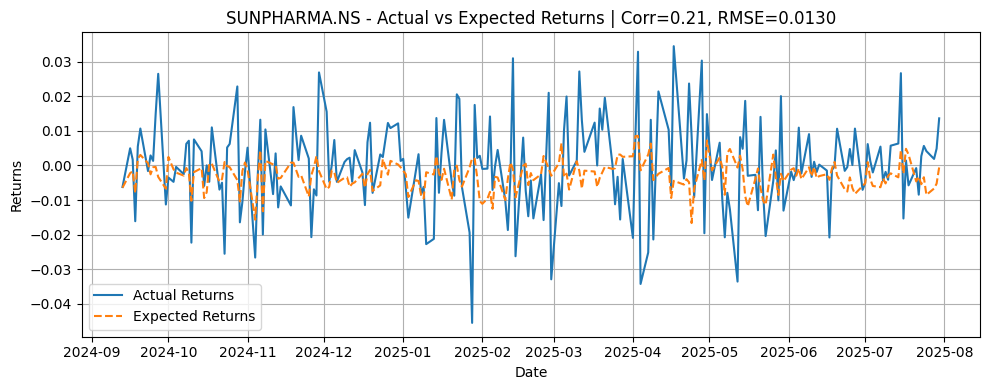

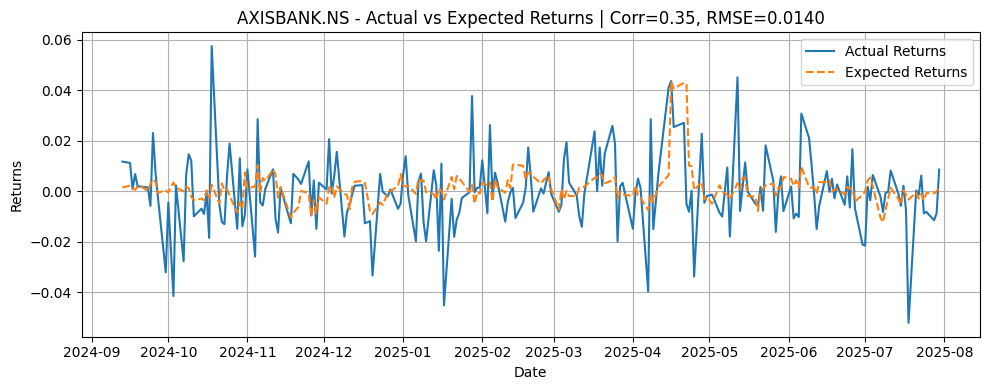

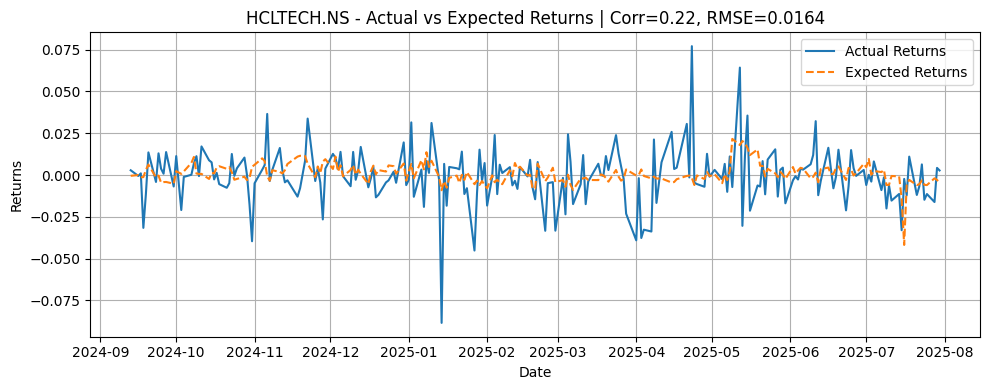

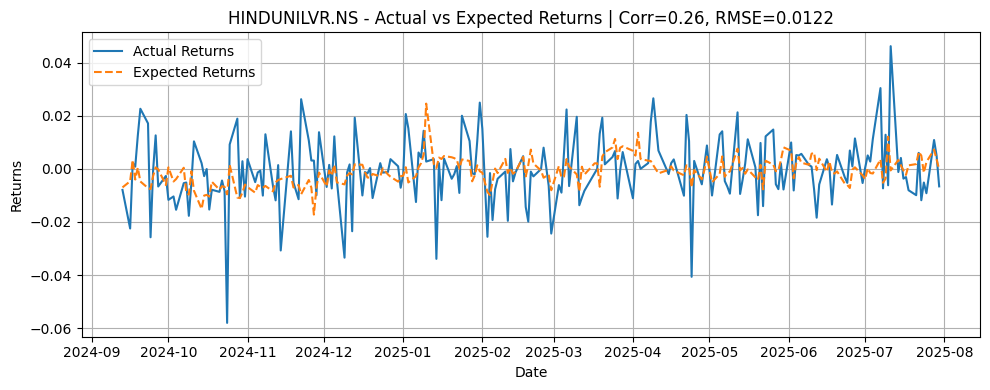

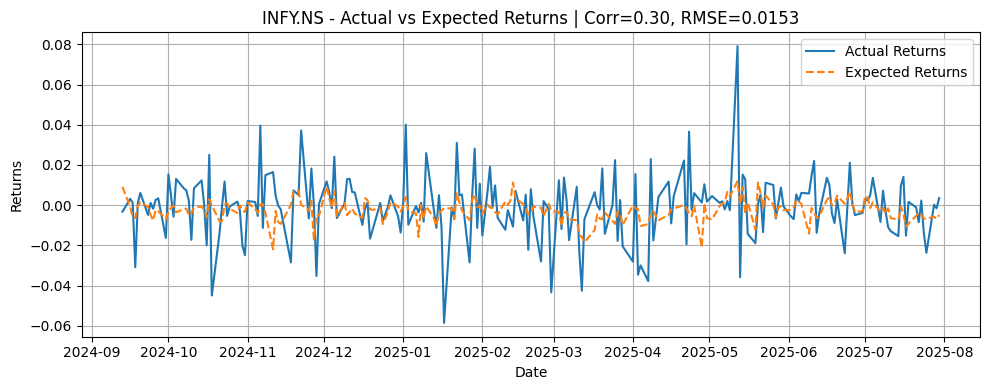

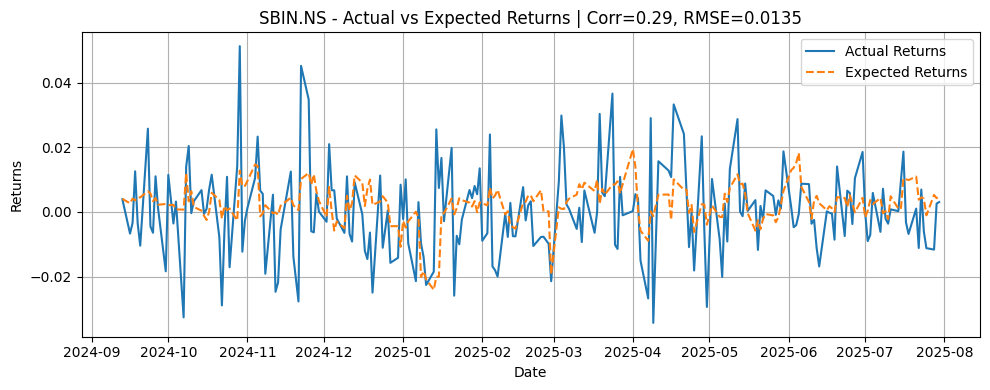

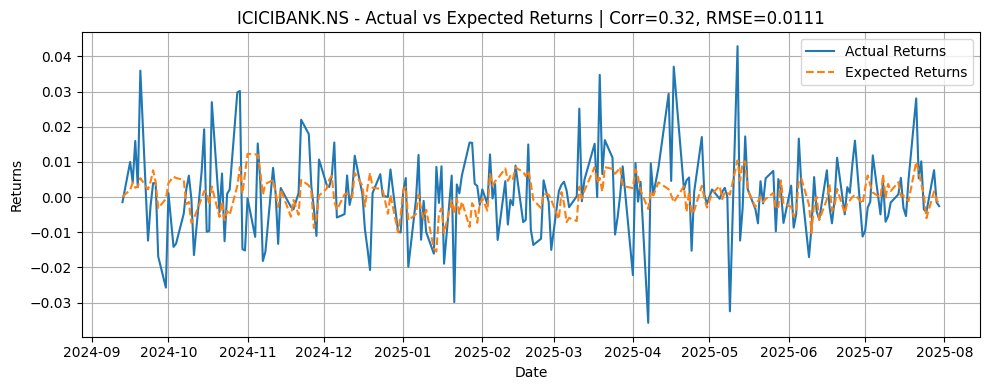

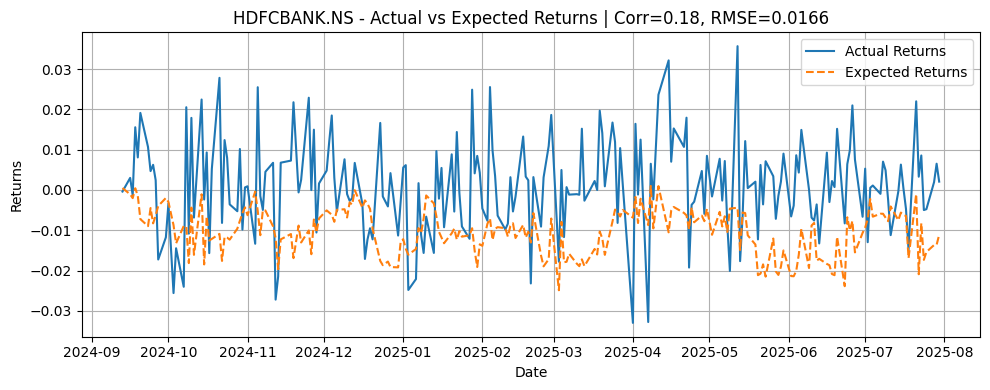

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

for ticker in tickers:
    actual = actual_returns[ticker].dropna()
    expected = expected_returns[ticker].dropna()

    # Align indices to avoid mismatch
    aligned = actual.align(expected, join='inner')
    actual = aligned[0]
    expected = aligned[1]

    # Calculate metrics
    correlation = np.corrcoef(actual, expected)[0, 1]
    rmse = np.sqrt(mean_squared_error(actual, expected))

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(actual.index, actual, label='Actual Returns')
    plt.plot(expected.index, expected, label='Expected Returns', linestyle='--')
    plt.title(f"{ticker} - Actual vs Expected Returns | Corr={correlation:.2f}, RMSE={rmse:.4f}")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()

In [ ]:
import yfinance as yf

metrics = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info
    pe = info.get('trailingPE')  # or 'forwardPE' if you prefer
    de = info.get('debtToEquity')
    mkt = info.get('marketCap')
    metrics[ticker] = {'PE Ratio': pe, 'Debt-to-Equity': de,'MktCap':mkt}

pe_de_df = pd.DataFrame(metrics).T
print(pe_de_df)


                PE Ratio  Debt-to-Equity        MktCap
BHARTIARTL.NS  31.544468         126.505  1.114491e+13
LTIM.NS        31.545820           9.814  1.484920e+12
HDFCLIFE.NS    86.934930          17.309  1.641483e+12
NTPC.NS        18.382757         130.856  3.245960e+12
MARUTI.NS      27.248135           0.090  3.958334e+12
NESTLEIND.NS   68.021090          29.106  2.114392e+12
BAJFINANCE.NS  31.248665         294.158  5.449821e+12
KOTAKBANK.NS   20.283577             NaN  3.882592e+12
TATASTEEL.NS   43.512394         103.775  1.969921e+12
ONGC.NS         8.102742          50.187  2.936745e+12
BAJAJ-AUTO.NS  30.303251          26.301  2.296025e+12
LT.NS          31.250866         114.735  4.961749e+12
ITC.NS         25.971178           0.405  5.191778e+12
TCS.NS         22.321547           9.714  1.098597e+13
BRITANNIA.NS   59.171790          28.451  1.297556e+12
ADANIENT.NS    40.001840         162.597  2.513920e+12
CIPLA.NS       22.272524           1.404  1.200161e+12
WIPRO.NS  

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np


df_scores = expected_returns.mean().to_frame(name='ExpectedReturn')
df_scores['PE'] = pe_de_df['PE Ratio']
df_scores['DE'] = pe_de_df['Debt-to-Equity']
df_scores['MktCap'] = pe_de_df['MktCap']

df_scores = df_scores.dropna()


scaler = MinMaxScaler()

df_scores['ReturnScore'] = scaler.fit_transform(df_scores[['ExpectedReturn']])
df_scores['PEScore'] = scaler.fit_transform(-df_scores[['PE']])
df_scores['DEScore'] = scaler.fit_transform(-df_scores[['DE']])
df_scores['MktCapScore'] = scaler.fit_transform(df_scores[['MktCap']])


w_r = float(input("Enter weight for ReturnScore: "))
w_p = float(input("Enter weight for PEScore: "))
w_d = float(input("Enter weight for DEScore: "))
w_m = float(input("Enter weight for MktCapScore: "))
if w_r + w_p + w_d + w_m != 1.0:
    raise ValueError("Weights must sum to 1.0")

df_scores['FinalScore'] = (w_r * df_scores['ReturnScore'] +
                           w_p * df_scores['PEScore'] +
                           w_d * df_scores['DEScore']+
                           w_m*df_scores['MktCapScore'])

# Select top 20
top_10 = df_scores.sort_values('FinalScore', ascending=False).head(10)['FinalScore']
print(top_10)


Enter weight for ReturnScore: 0.5
Enter weight for PEScore: 0.1
Enter weight for DEScore: 0.2
Enter weight for MktCapScore: 0.2
RELIANCE.NS      0.859543
HEROMOTOCO.NS    0.783519
BHARTIARTL.NS    0.762616
HCLTECH.NS       0.725657
COALINDIA.NS     0.722884
MARUTI.NS        0.722428
ASIANPAINT.NS    0.722422
NTPC.NS          0.699197
M&M.NS           0.691803
EICHERMOT.NS     0.681951
Name: FinalScore, dtype: float64


In [ ]:
def plot_final_scores(top_stocks):
    """Bar chart of final scores for top stocks."""
    symbols, scores = zip(*list(top_stocks.items())[:20])

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(scores), y=list(symbols), palette='viridis')
    plt.xlabel('Final Score')
    plt.ylabel('Stock Symbol')
    plt.title('Top 10 Stocks by Score')
    plt.show()

/tmp/ipython-input-810000572.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=list(symbols), palette='viridis')


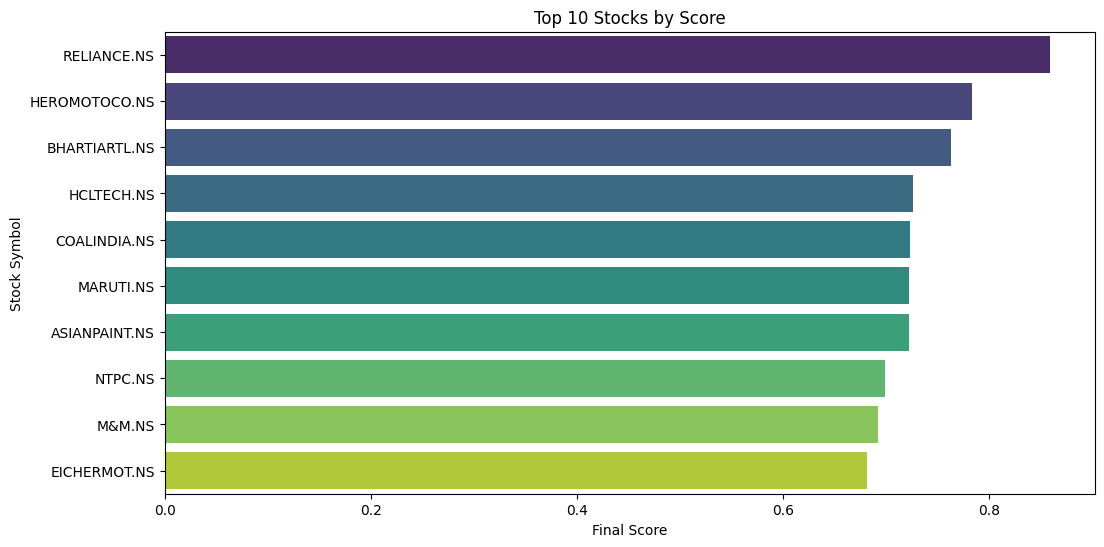

In [ ]:
plot_final_scores(top_10)

In [ ]:
pe_de_df

PE Ratio  Debt-to-Equity        MktCap
BHARTIARTL.NS  31.544468         126.505  1.114491e+13
LTIM.NS        31.545820           9.814  1.484920e+12
HDFCLIFE.NS    86.934930          17.309  1.641483e+12
NTPC.NS        18.382757         130.856  3.245960e+12
MARUTI.NS      27.248135           0.090  3.958334e+12
NESTLEIND.NS   68.021090          29.106  2.114392e+12
BAJFINANCE.NS  31.248665         294.158  5.449821e+12
KOTAKBANK.NS   20.283577             NaN  3.882592e+12
TATASTEEL.NS   43.512394         103.775  1.969921e+12
ONGC.NS         8.102742          50.187  2.936745e+12
BAJAJ-AUTO.NS  30.303251          26.301  2.296025e+12
LT.NS          31.250866         114.735  4.961749e+12
ITC.NS         25.971178           0.405  5.191778e+12
TCS.NS         22.321547           9.714  1.098597e+13
BRITANNIA.NS   59.171790          28.451  1.297556e+12
ADANIENT.NS    40.001840         162.597  2.513920e+12
CIPLA.NS       22.272524           1.404  1.200161e+12
WIPRO.NS       18.661201          18.233  2.508400e+12
INDUSINDBK.NS  60.608060             NaN  6.095724e+11
ULTRACEMCO.NS  52.909430          32.618  3.576018e+12
TATACONSUM.NS  78.141266          11.186  1.040000e+12
BAJAJFINSV.NS  32.572980         221.494  3.063523e+12
RELIANCE.NS    22.728481          36.605  1.850976e+13
HEROMOTOCO.NS  18.281467           3.607  9.202728e+11
COALINDIA.NS    7.061559           9.150  2.339989e+12
TITAN.NS       82.641510         178.742  3.069353e+12
HINDALCO.NS     9.354144          53.056  1.504982e+12
APOLLOHOSP.NS  70.422460          90.886  1.018645e+12
TECHM.NS       28.902773           7.287  1.310206e+12
DRREDDY.NS     17.793772          13.751  1.008543e+12
DIVISLAB.NS    68.029670           0.027  1.570116e+12
EICHERMOT.NS   32.154213           2.151  1.553236e+12
BPCL.NS        10.235502          75.077  1.386368e+12
SBILIFE.NS     74.084850             NaN  1.837909e+12
GRASIM.NS      44.644222         118.847  1.826393e+12
JSWSTEEL.NS    52.909730         122.497  2.559649e+12
ASIANPAINT.NS  65.787930          11.418  2.373019e+12
POWERGRID.NS   17.792006         145.251  2.649743e+12
ADANIPORTS.NS  25.315247          79.193  2.862185e+12
M&M.NS         25.706810         145.369  3.772128e+12
TATAMOTORS.NS   9.756737          61.549  2.333100e+12
SUNPHARMA.NS   36.632042           3.259  3.807497e+12
AXISBANK.NS    11.819705             NaN  3.282332e+12
HCLTECH.NS     23.584784           9.377  3.998129e+12
HINDUNILVR.NS  54.352840           3.322  5.870686e+12
INFY.NS        21.051775           8.894  5.898991e+12
SBIN.NS         9.251207             NaN  7.424187e+12
ICICIBANK.NS   19.530740             NaN  1.025122e+13
HDFCBANK.NS    22.574337             NaN  1.514953e+13

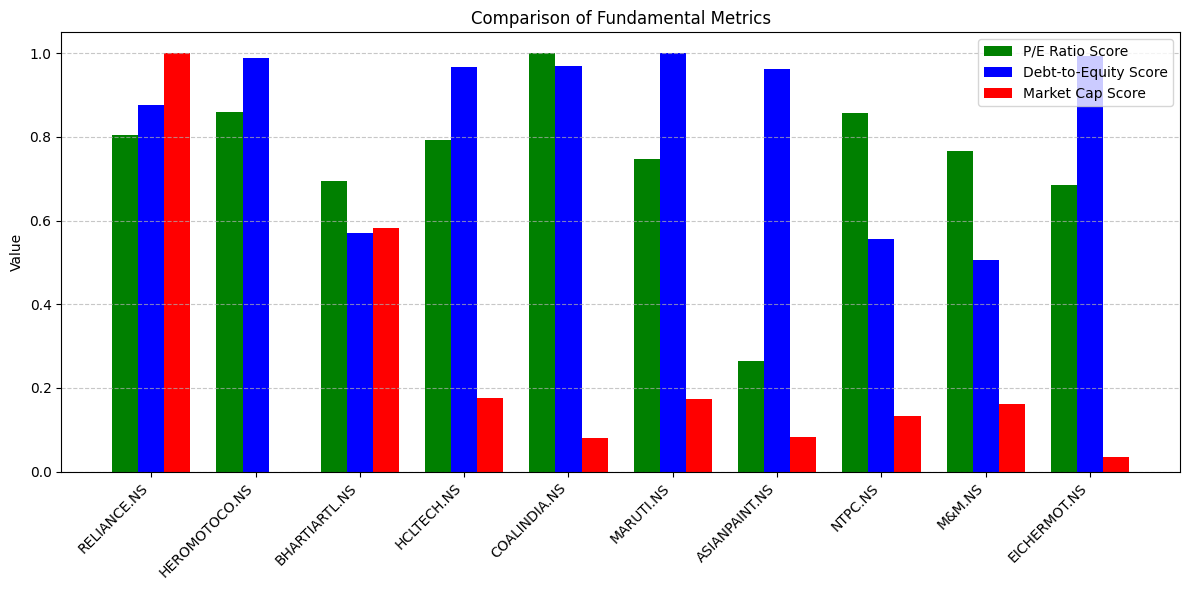

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


top15_metrics = df_scores.loc[top_10.index].dropna()

# Data
tickers_list = top15_metrics.index
pe_values = top15_metrics['PEScore']
de_values = top15_metrics['DEScore']
mk_values = top15_metrics['MktCapScore']

# Bar positions
x = np.arange(len(tickers_list))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, pe_values, width, label='P/E Ratio Score', color='green')
ax.bar(x , de_values, width, label='Debt-to-Equity Score', color='blue')
ax.bar(x + width, mk_values, width, label='Market Cap Score', color='red')

ax.set_ylabel('Value')
ax.set_title('Comparison of Fundamental Metrics')
ax.set_xticks(x)
ax.set_xticklabels(tickers_list, rotation=45, ha='right')
ax.legend()


ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
stocks=top_10.index
print(list(stocks))


['RELIANCE.NS', 'HEROMOTOCO.NS', 'BHARTIARTL.NS', 'HCLTECH.NS', 'COALINDIA.NS', 'MARUTI.NS', 'ASIANPAINT.NS', 'NTPC.NS', 'M&M.NS', 'EICHERMOT.NS']


IMPLEMENTING BLACK LITTERMAN MODEL ON TOP 'N' STOCKS

In [ ]:
stocks=list(top_10.index)
data = yf.download(stocks, start="2020-01-01", end="2024-12-31")['Close']
data.dropna(axis=1, inplace=True)

/tmp/ipython-input-319890581.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start="2020-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  10 of 10 completed


In [ ]:
stocks[0]

'RELIANCE.NS'

In [ ]:
def calculate_log_returns(price_df):
    return np.log(price_df / price_df.shift(1))

returns = calculate_log_returns(data)

In [ ]:
mu_sample = returns.mean()#sample mean
cov_sample = returns.cov()# sample covariance

In [ ]:
# Assuming equal weights for market portfolio (simplification)
w_mkt = np.ones(len(returns.columns)) / len(returns.columns)

In [ ]:
# implied equilibrium returns (Pi)

def implied_returns(cov_matrix, market_weights, risk_aversion):
    # Pi = delta * Sigma * w_mkt
    return risk_aversion * cov_matrix @ market_weights

In [ ]:
risk_aversion = 2.5 # typical value
pi = implied_returns(cov_sample, w_mkt, risk_aversion)

In [ ]:
stocks

['RELIANCE.NS',
 'HEROMOTOCO.NS',
 'BHARTIARTL.NS',
 'HCLTECH.NS',
 'COALINDIA.NS',
 'MARUTI.NS',
 'ASIANPAINT.NS',
 'NTPC.NS',
 'M&M.NS',
 'EICHERMOT.NS']

In [ ]:
# Step 7: Formulate Views
# View 1: stock 1 will outperform stock2 by 2%
# View 2: stock3 will underperform stock4 by 3%
# View 3: stock4 will outperform stock5 by 1.5%
P = np.zeros((3, len(stocks)))
P[0, stocks.index(stocks[0])] = 1
P[0, stocks.index(stocks[1])] = -1
P[1, stocks.index(stocks[2])] = -1
P[1, stocks.index(stocks[3])] = 1
P[2, stocks.index(stocks[4])] = 1
P[2, stocks.index(stocks[5])] = -1

Q = np.array([0.02, -0.03, 0.015])

In [ ]:

# Define the Omega matrix (view uncertainty)
Omega = np.diag([0.0001, 0.0001, 0.0001])  # TODO: Fill in based on confidence (e.g. 0.0001)

In [ ]:
# Black-Litterman Posterior
def black_litterman_posterior(cov, pi, P, Q, Omega, tau=0.025):
    # τΣ: scaled prior covariance
    # μ_bl = [(τΣ)^(-1) + PᵀΩ⁻¹P]^(-1) * [(τΣ)^(-1)π + PᵀΩ⁻¹Q]
    # Σ_bl = [(τΣ)^(-1) + PᵀΩ⁻¹P]^(-1)
    tau_cov = tau * cov

    inv_tau_cov = np.linalg.inv(tau_cov)
    inv_Omega = np.linalg.inv(Omega)

    M = np.linalg.inv(inv_tau_cov + P.T @ inv_Omega @ P)
    mu_bl = M @ (inv_tau_cov @ pi + P.T @ inv_Omega @ Q)

    return mu_bl, M


In [ ]:
mu_bl, cov_bl = black_litterman_posterior(cov_sample, pi, P, Q, Omega)

In [ ]:
#using PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
def mean_variance_opt(mu, cov, allow_short=False):
    ef = EfficientFrontier(mu,cov)
    ef.max_sharpe()
    return ef.clean_weights()

In [ ]:
optimal_weights = mean_variance_opt(mu_bl, cov_bl)
optimal_weights = np.array(list(optimal_weights.items()))
optimal_weights = np.array(list(optimal_weights[x][1] for x in range(len(optimal_weights))))
optimal_weights

array([0.16433, 0.     , 0.66171, 0.     , 0.17396, 0.     , 0.     ,
       0.     , 0.     , 0.     ])

In [ ]:
w_mkt

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
pd.Series(optimal_weights, index=returns.columns)

Ticker
ASIANPAINT.NS    0.16433
BHARTIARTL.NS    0.00000
COALINDIA.NS     0.66171
EICHERMOT.NS     0.00000
HCLTECH.NS       0.17396
HEROMOTOCO.NS    0.00000
M&M.NS           0.00000
MARUTI.NS        0.00000
NTPC.NS          0.00000
RELIANCE.NS      0.00000
dtype: float64

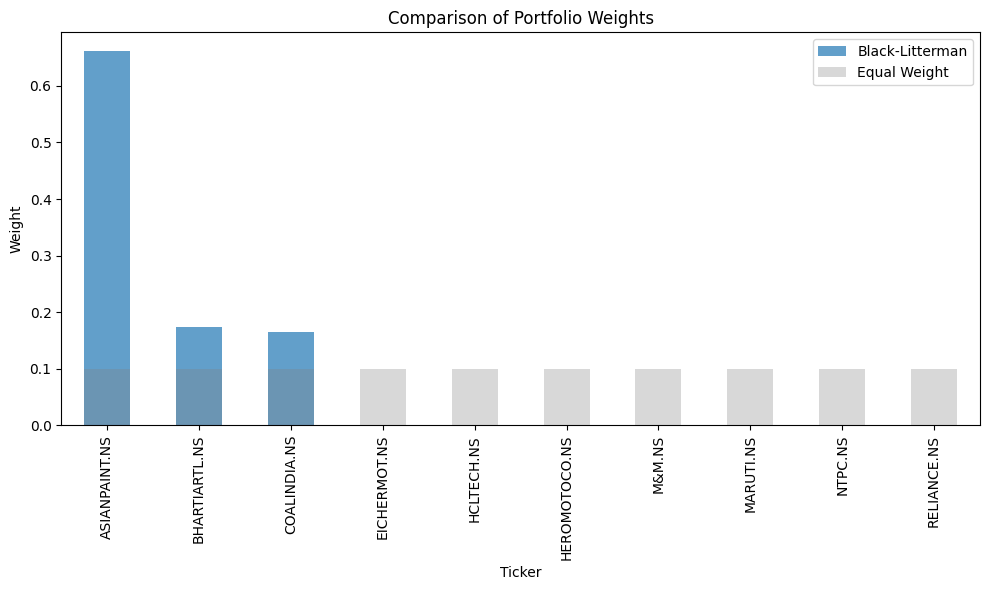

In [ ]:


portfolio_bl = pd.Series(optimal_weights, index=returns.columns)
portfolio_bl = portfolio_bl[portfolio_bl > 0.01].sort_values(ascending=False)


portfolio_equal = pd.Series(w_mkt, index=returns.columns)
portfolio_equal = portfolio_equal[portfolio_equal > 0.01].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
portfolio_bl.plot(kind='bar', ax=ax, label='Black-Litterman', alpha=0.7)
portfolio_equal.plot(kind='bar', ax=ax, color='gray', label='Equal Weight', alpha=0.3)
plt.title('Comparison of Portfolio Weights')
plt.ylabel('Weight')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

def simulate_portfolio(returns, weights,weights2):
    portfolio_returns = returns @ weights
    cumulative_returns = (1 + portfolio_returns).cumprod()
    portfolio_returns2 = returns @ weights2
    cumulative_returns2 = (1 + portfolio_returns2).cumprod()

    plt.figure(figsize=(12, 5))
    plt.plot(cumulative_returns, label='Our Portfolio')
    plt.plot(cumulative_returns2, label='Market Portfolio')
    plt.title("Portfolio Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cumulative_returns

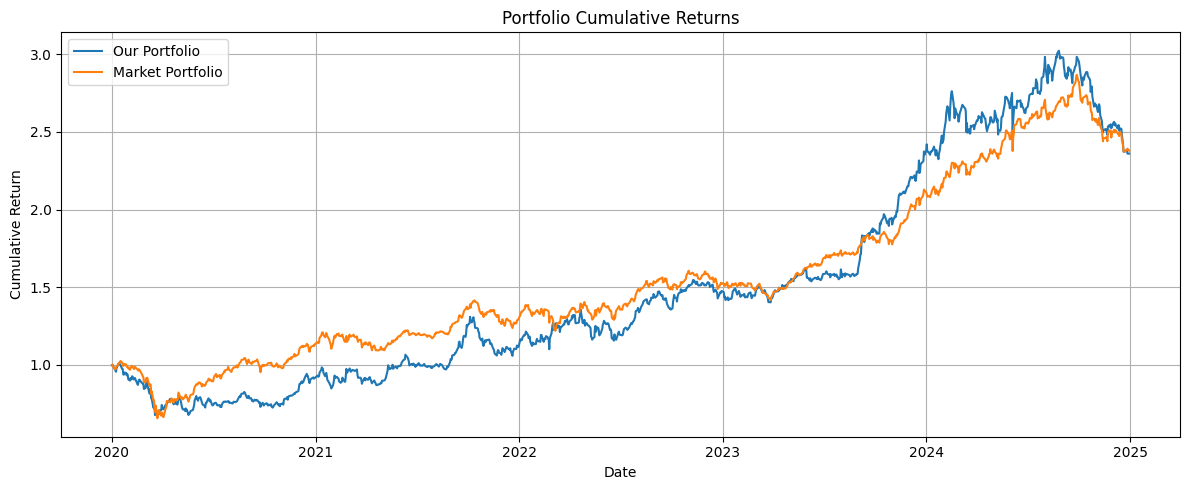

Date
2020-01-01         NaN
2020-01-02    0.997593
2020-01-03    0.999746
2020-01-06    0.975144
2020-01-07    0.977410
                ...   
2024-12-23    2.374131
2024-12-24    2.379982
2024-12-26    2.385672
2024-12-27    2.360207
2024-12-30    2.360306
Length: 1237, dtype: float64

In [ ]:
simulate_portfolio(returns, optimal_weights,w_mkt)